# Figure S6

### Import packages

In [1]:
%load_ext nb_black

import scdiffeq as sdq
import dev
import cellplots as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import ABCParse
import os
import pathlib
import seaborn as sns
import larry
import scipy.stats
import glob
import matplotlib

<IPython.core.display.Javascript object>

### Read data and load project

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

In [3]:
project = sdq.io.Project(path="./LightningSDE-FixedPotential-RegularizedVelocityRatio/")

<IPython.core.display.Javascript object>

### Compute fate prediction accuracy for each version

In [4]:
RATIOS = {}
for version, path in project._VERSION_PATHS.items():
    try:
        v = getattr(project, version)
        acc = dev.fate_prediction_accuracy(v)
        target_ratio = v.hparams["velocity_ratio_params"]["target"]
        RATIOS[version] = target_ratio, v, acc
    except:
        pass

<IPython.core.display.Javascript object>

### For each un-regularized training run, compute drift [`f`] and diffusion [`g`]

In [5]:
def f(df, key="training"):
    return df.filter(regex="velo_f").filter(regex=key).dropna().sum(1).mean()


def g(df, key="training"):
    return df.filter(regex="velo_g").filter(regex=key).dropna().sum(1).mean()


UnEnforcedResults = {}
for en, (version, results) in enumerate(RATIOS.items()):
    target_ratio, v, acc = results
    if v.hparams["velocity_ratio_params"]["enforce"] == 0:
        print(version)
        grouped = v.metrics_df.groupby("epoch")
        UnEnforcedResults[version] = {
            "f_training": grouped.apply(f, key="training"),
            "f_validation": grouped.apply(f, key="validation"),
            "g_training": grouped.apply(g, key="training"),
            "g_validation": grouped.apply(g, key="validation"),
        }

version_0
version_1
version_2
version_3
version_4


<IPython.core.display.Javascript object>

### Compute the empirical unenforced ratio

In [6]:
unenforced_ratio = np.array(
    [
        v["f_validation"].iloc[-1] / v["g_validation"].iloc[-1]
        for i, (k, v) in enumerate(UnEnforcedResults.items())
    ]
)
unenforced_ratio.mean(), unenforced_ratio.std()

(0.3669882612570243, 0.13488926187436895)

<IPython.core.display.Javascript object>

In [7]:
rel = unenforced_ratio / (1 + unenforced_ratio)
print(rel.mean(), rel.std())
print(unenforced_ratio.mean() / (1 + unenforced_ratio.mean()))

0.26198354528285633 0.06584885182554004
0.2684648227480443


<IPython.core.display.Javascript object>

In [8]:
OrgResults = {}
for en, (version, results) in enumerate(RATIOS.items()):
    target_ratio, v, acc = results
    if v.hparams["velocity_ratio_params"]["enforce"] == 0:
        target_ratio = unenforced_ratio.mean()  # 0.3669882612570243
    if not target_ratio in OrgResults.keys():
        OrgResults[target_ratio] = []
    best = acc[acc.loc["unique_train.all_fates"].idxmax()]["unique_test.all_fates"]
    OrgResults[target_ratio].append(best)

<IPython.core.display.Javascript object>

In [9]:
sorted_results = {
    key: OrgResults[key]
    for key in sorted(np.array(list(OrgResults.keys())).astype(float))
}

<IPython.core.display.Javascript object>

In [10]:
for k, v in sorted_results.items():
    print("{:>9.4f} {:.3f}  {:.4f} | {}".format(k, np.mean(v), np.std(v), len(v)))

   0.0010 0.523  0.0164 | 5
   0.0100 0.499  0.0253 | 5
   0.3670 0.513  0.0271 | 5
   0.5000 0.520  0.0320 | 5
   1.0000 0.530  0.0160 | 5
   1.5000 0.506  0.0154 | 5
   2.2500 0.529  0.0386 | 5
   2.5000 0.548  0.0260 | 5
   3.0000 0.522  0.0381 | 5
   5.0000 0.530  0.0157 | 5
  10.0000 0.523  0.0347 | 5
  20.0000 0.391  0.0713 | 5
  30.0000 0.292  0.0467 | 4


<IPython.core.display.Javascript object>

## Plot `F_obs` and `F_hat`

In [11]:
matplotlib.rcParams["xtick.major.width"] = 0.5


class FateBiasHeatmap(ABCParse.ABCParse):

    def __init__(self, savedir=os.getcwd(), *args, **kwargs):
        self.__parse__(locals())

        self.img_dir = pathlib.Path(savedir).joinpath("F_hat_plots")
        if not self.img_dir.exists():
            self.img_dir.mkdir()

        self._plot_obs()

    @property
    def _LARRY_cmap(self):
        return larry.pl.InVitroColorMap()._dict

    def _col_filter(self, df, search_cols):
        return df[[col for col in search_cols if col in df.columns]]

    @property
    def F_obs(self):
        if not hasattr(self, "_F_obs"):
            self._F_obs = larry.tasks.fate_prediction.F_obs
        return self._F_obs

    def _plot_obs(self):
        self.cg = sns.clustermap(
            self.F_obs,
            figsize=(3, 5),
            cmap="Blues",
            xticklabels=self.F_obs.columns,
            yticklabels=[],
            cbar_pos=None,  # cbar_pos,
            vmin=0,
            vmax=1,
            center=0.5,
            col_colors=[self._LARRY_cmap[fate] for fate in self.F_obs.columns],
            rasterized=True,
        )
        self.cg.ax_heatmap.set_title("True fate bias", fontsize=10, y=1.3)

        plt.savefig(self.img_dir.joinpath("F_obs.png"))

    @property
    def clustered_cells(self):
        return self.cg.dendrogram_row.reordered_ind

    @property
    def clustered_fates(self):
        return self.cg.dendrogram_col.reordered_ind

    def augment_fate_columns(self, F_hat):
        """"""
        F_hat_ = F_hat.copy()
        for col in self.F_obs.columns:
            if not col in F_hat_:
                F_hat_[col] = 0

        return F_hat_

    def _compose_F_hat_plot(self, F_hat):

        F_hat_plot = self.augment_fate_columns(F_hat)
        F_hat_plot = F_hat_plot[self.F_obs.columns[self.clustered_fates]]
        return F_hat_plot.iloc[self.clustered_cells]

    def plot_F_hat(self, F_hat_plot, title):
        self._cg_F_hat = sns.clustermap(
            F_hat_plot,
            figsize=(3, 5),
            cmap="Blues",
            xticklabels=F_hat_plot.columns,
            yticklabels=[],
            cbar_pos=None,
            row_cluster=False,
            col_cluster=False,
            vmin=0,
            vmax=1,
            center=0.5,
            col_colors=[self._LARRY_cmap[fate] for fate in F_hat_plot.columns],
            rasterized=True,
        )
        if not title is None:
            self._cg_F_hat.ax_heatmap.set_title(title, fontsize=10, y=1.05)

    def __call__(self, F_hat, title=None, *args, **kwargs):
        self.__update__(locals())

        F_hat_plot = self._compose_F_hat_plot(F_hat)
        self.plot_F_hat(F_hat_plot, title=title)

<IPython.core.display.Javascript object>

In [12]:
def _test_from_best_train(acc):
    best_train_epoch = acc.loc["unique_train.all_fates"].idxmax()
    best_train = acc[best_train_epoch]
    return best_train_epoch, best_train["unique_test.all_fates"]


def _get_best_F_hat_path(version, best_epoch):
    """use glob to filter and grab the right saved F_hat"""
    try:
        regex = f"LightningSDE-FixedPotential-RegularizedVelocityRatio/version_{version}/fate_prediction_metrics/{best_epoch}*/F_hat.processed.csv"
        return glob.glob(regex)[0]
    except:
        regex = f"LightningSDE-FixedPotential-RegularizedVelocityRatio/version_{version}/fate_prediction_metrics/on_train_end*/F_hat.processed.csv"
        print(regex)
        return glob.glob(regex)[0]


def _convert_best_epoch_name(row):
    if row["best_epoch"] == 2500:
        return "last"
    if row["best_epoch"] == 2499:
        return "on_train_end"
    return f"epoch_{row['best_epoch']}"


def get_best_results(RATIOS):
    BestResults = []
    for en, (version, results) in enumerate(RATIOS.items()):
        if not version in ["version_46", "version_71"]:

            target_ratio, v, acc = results
            #             if target_ratio == 30:
            #                 print(acc)
            #                 print()
            #         if not str(target_ratio) in OrgResults.keys():
            #             BestResults[] = []

            best_epoch, best_score = _test_from_best_train(acc)
            v_key = version.split("version_")[-1]
            BestResults.append(
                {
                    "target_ratio": str(target_ratio),
                    "best_epoch": best_epoch,
                    "best_score": best_score,
                    "version": v_key,
                }
            )

    return pd.DataFrame(BestResults)

<IPython.core.display.Javascript object>

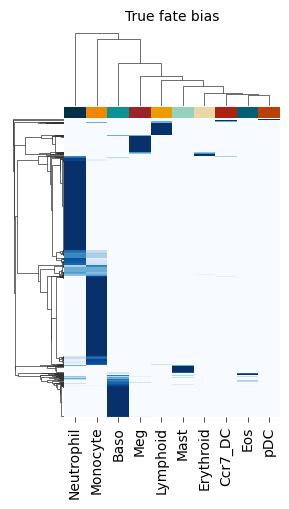

<IPython.core.display.Javascript object>

In [13]:
project_path = project._PROJECT_PATH

fate_bias_heatmap = FateBiasHeatmap()
paths = list(project_path.glob("*/fate_prediction_metrics/*/F_hat.processed.csv"))
plt.savefig("F_obs.svg", dpi=400)

In [14]:
best_results = get_best_results(RATIOS)
best_results

,target_ratio,best_epoch,best_score,version
0,2.0,1891,0.508731,0
1,2.0,2500,0.485448,1
2,5.0,2285,0.522701,10
3,0.01,1674,0.472643,11
4,1.0,1294,0.552969,12
...,...,...,...,...
58,2.25,1603,0.516880,62
59,2.25,2285,0.477299,63
60,5.0,1330,0.514552,7
61,5.0,1119,0.555297,8


<IPython.core.display.Javascript object>

In [15]:
best_results.loc[best_results["target_ratio"] == "3.0"]

,target_ratio,best_epoch,best_score,version
41,3.0,1339,0.579744,47
43,3.0,1311,0.474971,49
46,3.0,2499,0.540163,51
48,3.0,1341,0.528522,53
50,3.0,2500,0.485448,55


<IPython.core.display.Javascript object>

In [16]:
def get_grouped_F_hat_dfs(group_df):
    GroupF_hats = []
    for i, row in group_df.iterrows():
        #         print(row)
        F_hat_path = _get_best_F_hat_path(
            version=row["version"], best_epoch=_convert_best_epoch_name(row)
        )
        F_hat = pd.read_csv(F_hat_path, index_col=0)
        GroupF_hats.append(F_hat)
    return GroupF_hats

<IPython.core.display.Javascript object>

In [17]:
# "LightningSDE-FixedPotential-RegularizedVelocityRatio/version_59/fate_prediction_metrics/on_train_end.epoch_2500/"
best_results

,target_ratio,best_epoch,best_score,version
0,2.0,1891,0.508731,0
1,2.0,2500,0.485448,1
2,5.0,2285,0.522701,10
3,0.01,1674,0.472643,11
4,1.0,1294,0.552969,12
...,...,...,...,...
58,2.25,1603,0.516880,62
59,2.25,2285,0.477299,63
60,5.0,1330,0.514552,7
61,5.0,1119,0.555297,8


<IPython.core.display.Javascript object>

In [18]:
best_F_hats = (
    best_results.groupby("target_ratio").apply(get_grouped_F_hat_dfs).to_dict()
)

LightningSDE-FixedPotential-RegularizedVelocityRatio/version_50/fate_prediction_metrics/on_train_end*/F_hat.processed.csv


<IPython.core.display.Javascript object>

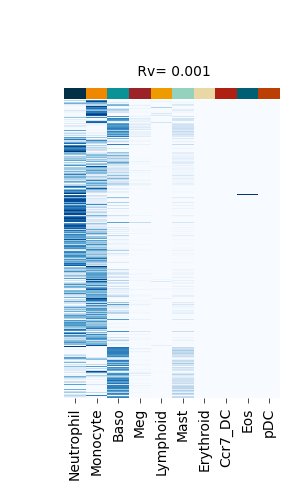

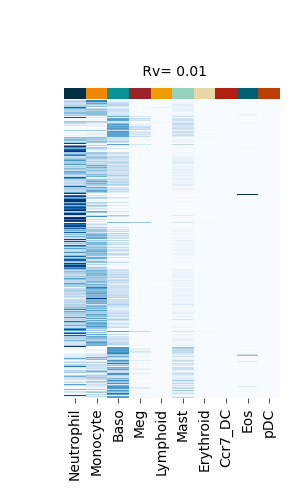

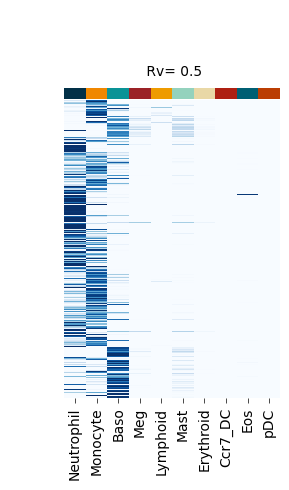

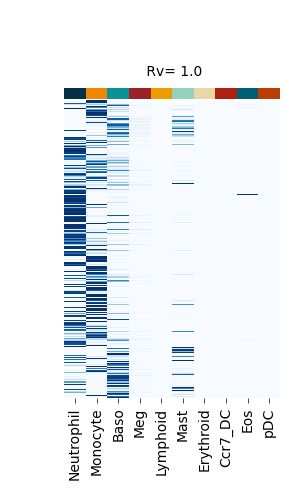

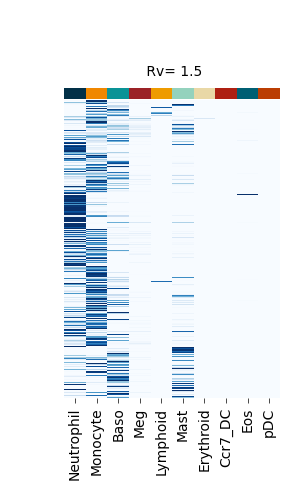

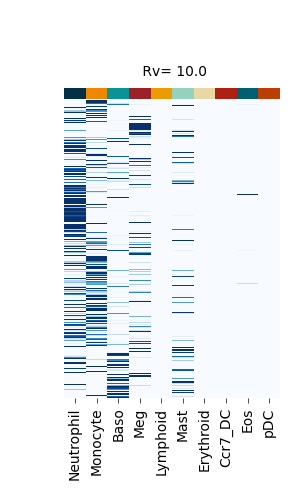

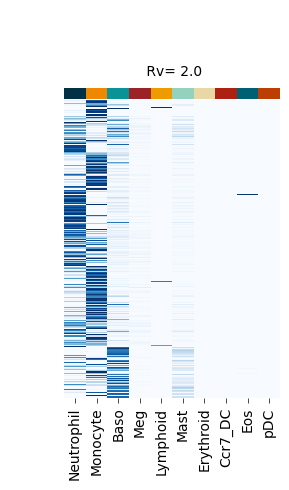

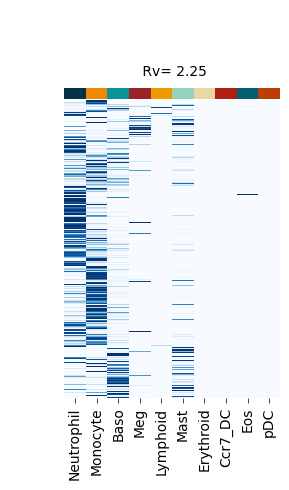

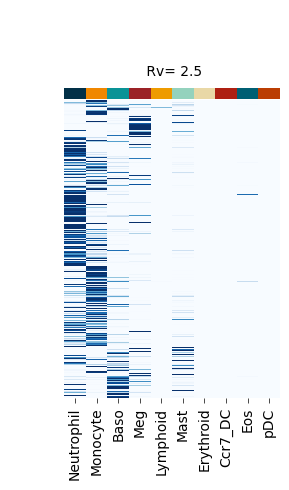

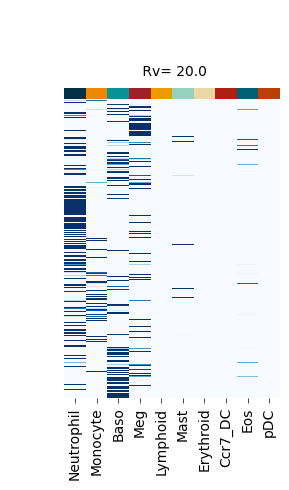

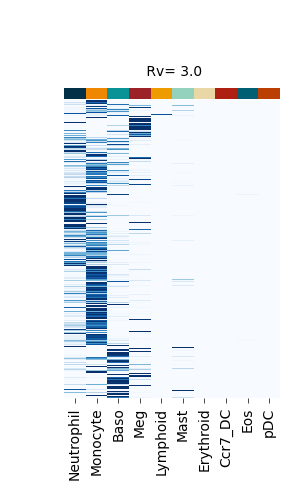

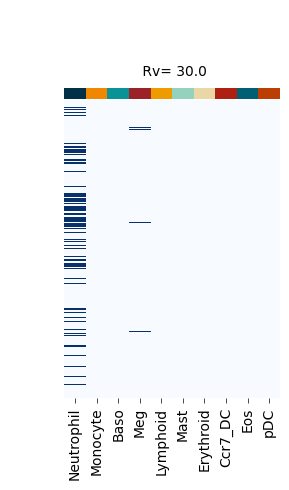

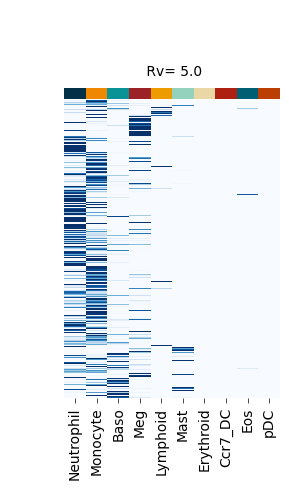

<IPython.core.display.Javascript object>

In [20]:
for k, v in best_F_hats.items():
    fate_bias_heatmap(F_hat=v[0], title=f" Rv= {k}")
    plt.savefig(f"./F_hat.Rv_{k}.svg", dpi=400)